# [Detecting the difficulty level of French texts](https://www.kaggle.com/c/detecting-the-difficulty-level-of-french-texts/overview/evaluation)
## Hyper parameters tuning
---
In this notebook, we will use cross-validation to find the best parameters of the models that showed the most promising result in first approach.

In [ ]:
# Download the french language model
!python -m spacy download fr_core_news_md

In [1]:
import pandas as pd
import spacy
from spacy import displacy
import string
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels
np.random.state = 0

def evaluate(y_true, pred):
    """
    Calculate the models performance metrics. 
    Since it is a multi-class classification, we take the weighted average 
    for the metrics that are calculated for each class.

    """

    report = {
      'accuracy':accuracy_score(y_true, pred),
      'recall':recall_score(y_true, pred, average='weighted'),
      'precision':precision_score(y_true, pred, average='weighted'),
      'f1_score':f1_score(y_true, pred, average='weighted')
    }

    return report

def plot_confusion_matrix(y_true, pred):
    
    """
    A function to plot the models confusion matrix.
    """

    cf_matrix = confusion_matrix(y_test, pred)

    fig, ax = plt.subplots(1,1, figsize=(9, 6))

    sns.heatmap(cf_matrix, ax=ax, annot=True, 
              annot_kws={"size": 16}, fmt='g')

    ax.set_xticklabels(y_true.iloc[:6])
    ax.set_yticklabels(y_true.iloc[:6])

    ax.set_ylabel("Actual")
    ax.set_xlabel("Predicted")
    ax.set_title("Confusion matrix")


sp = spacy.load('fr_core_news_md')

# Import stopwords from spacy french language
stop_words = spacy.lang.fr.stop_words.STOP_WORDS
# Import punctations characters
punctuations = string.punctuation

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/LaCrazyTomato/Group-Project-DM-ML-2021/main/data/training_data.csv")

df.head()

,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2,Le test de niveau en français est sur le site ...,A1
3,3,Est-ce que ton mari est aussi de Boston?,A1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1


This time we will optimize the Tokenizer, with the aim of reducing the dimensionality and improve accuracy. To do this, we will use the PorterStemmer combined with the WordNetLemmatizer of nltk, in order to keep only the root of the words.

We kept stop-words, number and punctations because we believed their number of occurences can be predictors of a sentence complexity (and this looks like to be the case because accuracy on testing set reduce when we keep them).

In [3]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
nltk.download('punkt')

# Define cleaning function
def nltk_tokenizer(doc):
    
    # Lowercase
    doc = doc.lower()
    
    # Tokenize and remove white spaces (strip)
    doc = word_tokenize(doc)
    doc = [word.lower().strip() for word in doc]
    
    stemmer = PorterStemmer()
    doc = [stemmer.stem(word) for word in doc]
    
    lemma = WordNetLemmatizer()
    doc = [lemma.lemmatize(word) for word in doc]
    
    return doc


print(nltk_tokenizer(df.loc[2, 'sentence']))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['le', 'test', 'de', 'niveau', 'en', 'françai', 'est', 'sur', 'le', 'site', 'internet', 'de', "l'école", '.']


In [4]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=nltk_tokenizer)

In [5]:
X = df['sentence']
y = df['difficulty']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

X_train

183     Vous attendîtes la surprise que vos parents vo...
90                      Le petit chat a plu à mes parents
1128    Pourfendeur des sciences et des arts, fossoyeu...
2336    un berger est une personne chargée de guider e...
4398    Pendant les trois années d'études, je vivais d...
                              ...                        
3983    La Corse est une petite île au sud de la Franc...
1870                             Ma mère s'appelle Marie.
394     Le journaliste lui a posé des questions auxque...
3244    Les sentiments de l'homme sont confus et mélan...
411     Il n'engendre aucun mouvement alternatif, ce q...
Name: sentence, Length: 3840, dtype: object

# Models tuning
We will user [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) from sklearn, in order to find the best hyperparameters. What is good with this module is that, in addition to the parameters of the classifier, it allows us to optimize the parameters of all the preprocessor included in the pipeline (e.g: vectorizer, scaler, ...).

## 1. LogisticRegression
### 1.1 Remainder : accuracy from first approach -> 46.56 %

In [6]:

LRCV_model = LogisticRegression()

pipe = Pipeline([('vectorizer', tfidf_vectorizer),
                 ('classifier', LRCV_model)])

pipe.fit(X_train, y_train)


pred = pipe.predict(X_test)

evaluate(y_test, pred)


{'accuracy': 0.48125,
 'recall': 0.48125,
 'precision': 0.4774354650793071,
 'f1_score': 0.47669201368934977}

With optimized text cleaning, we managed to **increase accuracy by approximately 160 basis point.**

### 1.2 Tuning

In [6]:
from sklearn.datasets import make_classification
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV
import pandas as pd
from sklearn.preprocessing import StandardScaler

tfidf_vector = TfidfVectorizer()


LR_model = LogisticRegression(random_state=0)

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR_model)])

# We define here all the parameters we want the CV to do combination with.
param_grid = {'classifier__solver': ['lbfgs'],
              'classifier__penalty': ['l2', 'none'],
              'classifier__max_iter': [10_000],
              'vectorizer__tokenizer':[nltk_tokenizer],
              'vectorizer__ngram_range':[(1,3), (1,4), (1,5), (1,6)],
              'vectorizer__analyzer':['word', 'char'],
              'vectorizer__norm':['l1', 'l2'],
              'vectorizer__max_df':[0.7, 0.8, 0.9, 1.0],
              'vectorizer__min_df':[0, 1, 2],
             }

grid_search_params = dict(estimator=pipe,
                          param_grid=param_grid,
                          verbose=10)

LR_cross_validation = GridSearchCV(**grid_search_params)

LR_cross_validation



GridSearchCV(estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier',
                                        LogisticRegression(random_state=0))]),
             param_grid={'classifier__max_iter': [10000],
                         'classifier__penalty': ['l2', 'none'],
                         'classifier__solver': ['lbfgs'],
                         'vectorizer__analyzer': ['word', 'char'],
                         'vectorizer__max_df': [0.7, 0.8, 0.9, 1.0],
                         'vectorizer__min_df': [0, 1, 2],
                         'vectorizer__ngram_range': [(1, 3), (1, 4), (1, 5),
                                                     (1, 6)],
                         'vectorizer__norm': ['l1', 'l2'],
                         'vectorizer__tokenizer': [<function nltk_tokenizer at 0x0000021C1A19E318>]},
             verbose=10)

All the parameters combination gives **384 models possible**. For each of these, the cross-validation will do 5 split, which gives us a total number of fits of 1920.

It took a lot of time.. So we saved it in a csv file.

In [76]:
#%%time
#LR_cross_validation.fit(X, y)
#results = pd.DataFrame(LR_cross_validation.cv_results_)
#results.to_csv("LR_cross_validation.csv")

In [7]:
results = pd.read_csv("LR_cross_validation.csv")
results.head()

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_iter,param_classifier__penalty,param_classifier__solver,param_vectorizer__analyzer,param_vectorizer__max_df,...,param_vectorizer__tokenizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0,4.321114,0.253059,0.489479,0.002947,10000,l2,lbfgs,word,0.7,...,<function nltk_tokenizer at 0x0000021C1A19E318>,"{'classifier__max_iter': 10000, 'classifier__p...",0.418750,0.375000,0.368750,0.390625,0.382292,0.387083,0.017438,297
1,1,7.230842,0.680253,0.468461,0.023902,10000,l2,lbfgs,word,0.7,...,<function nltk_tokenizer at 0x0000021C1A19E318>,"{'classifier__max_iter': 10000, 'classifier__p...",0.476042,0.435417,0.428125,0.421875,0.426042,0.437500,0.019764,206
2,2,5.274098,0.145254,0.479631,0.013979,10000,l2,lbfgs,word,0.7,...,<function nltk_tokenizer at 0x0000021C1A19E318>,"{'classifier__max_iter': 10000, 'classifier__p...",0.383333,0.361458,0.350000,0.372917,0.364583,0.366458,0.011188,316
3,3,9.424096,0.813070,0.482579,0.013697,10000,l2,lbfgs,word,0.7,...,<function nltk_tokenizer at 0x0000021C1A19E318>,"{'classifier__max_iter': 10000, 'classifier__p...",0.465625,0.419792,0.415625,0.411458,0.417708,0.426042,0.019983,215
4,4,6.545410,0.103696,0.489211,0.034102,10000,l2,lbfgs,word,0.7,...,<function nltk_tokenizer at 0x0000021C1A19E318>,"{'classifier__max_iter': 10000, 'classifier__p...",0.360417,0.333333,0.331250,0.362500,0.353125,0.348125,0.013314,327


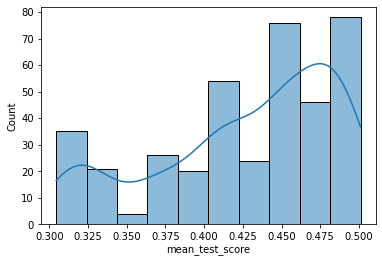

In [8]:
sns.histplot(results.mean_test_score, kde=True)

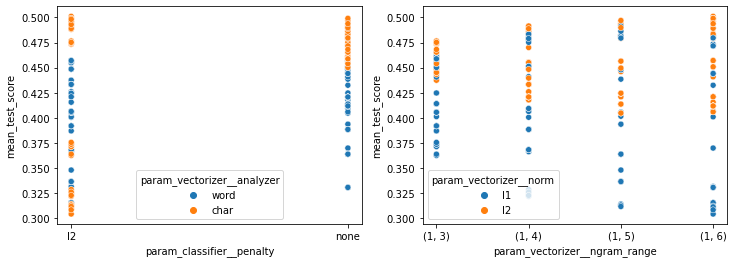

In [9]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

sns.scatterplot(data=results, x="param_classifier__penalty", 
                y="mean_test_score", 
                hue="param_vectorizer__analyzer",
               ax=ax[0])

sns.scatterplot(data=results, x="param_vectorizer__ngram_range", 
                y="mean_test_score", 
                hue="param_vectorizer__norm",
               ax=ax[1])


In [10]:
best = results[results.rank_test_score==1]

display(best)
dict(best.params)

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_iter,param_classifier__penalty,param_classifier__solver,param_vectorizer__analyzer,param_vectorizer__max_df,...,param_vectorizer__tokenizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
119,119,8.833449,0.356059,0.309594,0.006858,10000,l2,lbfgs,char,0.7,...,<function nltk_tokenizer at 0x0000021C1A19E318>,"{'classifier__max_iter': 10000, 'classifier__p...",0.513542,0.525,0.496875,0.485417,0.484375,0.501042,0.015934,1


{119: "{'classifier__max_iter': 10000, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'vectorizer__analyzer': 'char', 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 6), 'vectorizer__norm': 'l2', 'vectorizer__tokenizer': <function nltk_tokenizer at 0x0000021C1A19E318>}"}

### 1.2 Testing accuracy with best parameters found

In [12]:
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.preprocessing import StandardScaler


vectorizer = TfidfVectorizer(tokenizer=nltk_tokenizer, 
                               ngram_range=(1, 6),
                               analyzer='char',
                            min_df=2,
                            max_df=0.7,
                            norm='l2')


model = LogisticRegression(max_iter=10_000,
                          penalty='l2',
                          solver='lbfgs')

pipe = Pipeline([('vectorizer', vectorizer),                 
                 ('classifier', model)])


pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)


0.503125

We improved accuracy on testing set by 220 basis point.

## 2. Random Forest
### 2.1 Remainder : accuracy from first approach -> 39.79 %

For the vectorizer, we will keep best parameters previously.

In [14]:
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

vectorizer = TfidfVectorizer(tokenizer=nltk_tokenizer, 
                               ngram_range=(1, 6),
                               analyzer='char',
                            min_df=2,
                            max_df=0.7,
                            norm='l2')

random_forest_model = RandomForestClassifier(random_state=0)

pipe = Pipeline([('vectorizer', vectorizer),
                 ('classifier', random_forest_model)])

# We define here all the parameters we want the CV to do combination with.
param_grid = {'classifier__criterion': ['entropy', 'gini'],
              'classifier__min_samples_split': [2, 4, 6],
              'classifier__max_features': ["auto", "sqrt", "log2"],
             }

grid_search_params = dict(estimator=pipe,
                          param_grid=param_grid,
                          verbose=10)

random_forest_cross_validation = GridSearchCV(**grid_search_params)

random_forest_cross_validation



GridSearchCV(estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='char',
                                                        max_df=0.7, min_df=2,
                                                        ngram_range=(1, 6),
                                                        tokenizer=<function nltk_tokenizer at 0x00000169BE9A60D8>)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=0))]),
             param_grid={'classifier__criterion': ['entropy', 'gini'],
                         'classifier__max_features': ['auto', 'sqrt', 'log2'],
                         'classifier__min_samples_split': [2, 4, 6]},
             verbose=10)

In [98]:
#%%time
#random_forest_cross_validation.fit(X, y)
#results = pd.DataFrame(random_forest_cross_validation.cv_results_)
#results.to_csv("random_forest_cross_validation.csv")

In [15]:
results = pd.read_csv("random_forest_cross_validation.csv")

In [16]:
best = results[results.rank_test_score==1]

display(best)
dict(best.params)

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_features,param_classifier__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,9,8.956898,0.052415,0.458973,0.020465,gini,auto,2,"{'classifier__criterion': 'gini', 'classifier_...",0.473958,0.455208,0.448958,0.432292,0.427083,0.4475,0.016791,1
12,12,8.947438,0.116671,0.475529,0.014433,gini,sqrt,2,"{'classifier__criterion': 'gini', 'classifier_...",0.473958,0.455208,0.448958,0.432292,0.427083,0.4475,0.016791,1


{9: "{'classifier__criterion': 'gini', 'classifier__max_features': 'auto', 'classifier__min_samples_split': 2}",
 12: "{'classifier__criterion': 'gini', 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 2}"}

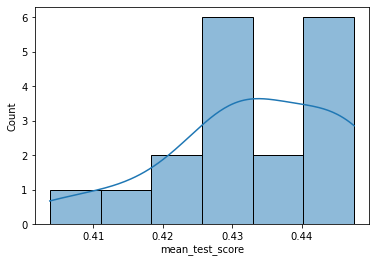

In [17]:
sns.histplot(results.mean_test_score, kde=True)

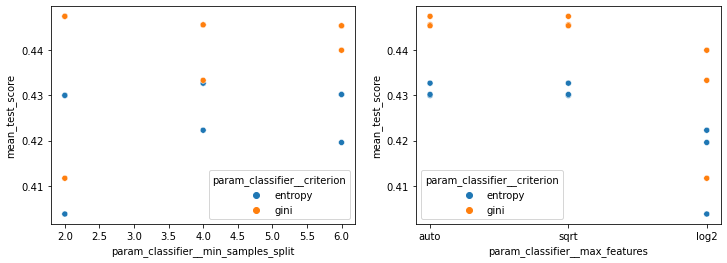

In [18]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

sns.scatterplot(data=results, x="param_classifier__min_samples_split", 
                y="mean_test_score", 
                hue="param_classifier__criterion",
               ax=ax[0])

sns.scatterplot(data=results, x="param_classifier__max_features", 
                y="mean_test_score", 
                hue="param_classifier__criterion",
               ax=ax[1])



### 2.2 Testing accuracy with best parameters found

In [19]:
vectorizer = TfidfVectorizer(tokenizer=nltk_tokenizer, 
                               ngram_range=(1, 6),
                               analyzer='char',
                            min_df=2,
                            max_df=0.7,
                            norm='l2')

model = RandomForestClassifier(criterion='gini',
                          max_features='auto',
                          min_samples_split=2)

pipe = Pipeline([('vectorizer', vectorizer),                 
                 ('classifier', model)])


pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)

0.4197916666666667

## 3. Ridge classifier
### 3.1 Remainder : accuracy from first approach -> 46.77 %

In [20]:
from sklearn.linear_model import RidgeClassifier


vectorizer = TfidfVectorizer(tokenizer=nltk_tokenizer, 
                               ngram_range=(1, 6),
                               analyzer='char',
                            min_df=2,
                            max_df=0.7,
                            norm='l2')

ridge_model = RidgeClassifier(random_state=0)

ridge_pipe = Pipeline([('vectorizer', vectorizer),
                 ('classifier', ridge_model)])


param_grid = {'classifier__alpha': [0.8, 1.0, 1.2],
              'classifier__max_iter': [10_000],
              'classifier__max_iter': [10_000],
              'classifier__solver':['auto', 'sparse_cg', 'sag']
             }

grid_search_params = dict(estimator=ridge_pipe,
                          param_grid=param_grid,
                          verbose=10)

ridge_cross_validation = GridSearchCV(**grid_search_params)

ridge_cross_validation


GridSearchCV(estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='char',
                                                        max_df=0.7, min_df=2,
                                                        ngram_range=(1, 6),
                                                        tokenizer=<function nltk_tokenizer at 0x00000169BE9A60D8>)),
                                       ('classifier',
                                        RidgeClassifier(random_state=0))]),
             param_grid={'classifier__alpha': [0.8, 1.0, 1.2],
                         'classifier__max_iter': [10000],
                         'classifier__solver': ['auto', 'sparse_cg', 'sag']},
             verbose=10)

In [21]:
#%%time
#ridge_cross_validation.fit(X, y)
#results = pd.DataFrame(ridge_cross_validation.cv_results_)
#results.to_csv("ridge_cross_validation.csv")

In [22]:
results = pd.read_csv("ridge_cross_validation.csv")

In [23]:
best = results[results.rank_test_score==1]

display(best)
dict(best.params)

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__max_iter,param_classifier__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,6,2.269414,0.038925,0.361831,0.004523,1.2,10000,auto,"{'classifier__alpha': 1.2, 'classifier__max_it...",0.516667,0.504167,0.478125,0.482292,0.486458,0.493542,0.014574,1
7,7,2.282232,0.019176,0.368016,0.041709,1.2,10000,sparse_cg,"{'classifier__alpha': 1.2, 'classifier__max_it...",0.516667,0.504167,0.478125,0.482292,0.486458,0.493542,0.014574,1
8,8,2.343749,0.068182,0.371394,0.035085,1.2,10000,sag,"{'classifier__alpha': 1.2, 'classifier__max_it...",0.516667,0.504167,0.478125,0.482292,0.486458,0.493542,0.014574,1


{6: "{'classifier__alpha': 1.2, 'classifier__max_iter': 10000, 'classifier__solver': 'auto'}",
 7: "{'classifier__alpha': 1.2, 'classifier__max_iter': 10000, 'classifier__solver': 'sparse_cg'}",
 8: "{'classifier__alpha': 1.2, 'classifier__max_iter': 10000, 'classifier__solver': 'sag'}"}

### 3.2 Testing accuracy with best parameters found

In [24]:
model = RidgeClassifier(random_state=0, 
                        max_iter=10_000, 
                        alpha=1.2,
                        solver='auto')

pipe = Pipeline([('vectorizer', vectorizer),                 
                 ('classifier', model)])


pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)

0.5041666666666667

## 4. Perceptron classifier
### 4.1 Remainder : accuracy from first approach -> 41.04 %

In [25]:
from sklearn.linear_model import Perceptron



vectorizer = TfidfVectorizer(tokenizer=nltk_tokenizer, 
                               ngram_range=(1, 6),
                               analyzer='char',
                            min_df=2,
                            max_df=0.7,
                            norm='l2')

perceptron_model = Perceptron(random_state=0)

perceptron_pipe = Pipeline([('vectorizer', vectorizer),
                            ('classifier', perceptron_model)])

param_grid = {'classifier__alpha': [0.0001, 0.0003, 0.005],
             }

grid_search_params = dict(estimator=perceptron_pipe,
                          param_grid=param_grid,
                          verbose=10)

perceptron_cross_validation = GridSearchCV(**grid_search_params)

perceptron_cross_validation

GridSearchCV(estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='char',
                                                        max_df=0.7, min_df=2,
                                                        ngram_range=(1, 6),
                                                        tokenizer=<function nltk_tokenizer at 0x00000169BE9A60D8>)),
                                       ('classifier', Perceptron())]),
             param_grid={'classifier__alpha': [0.0001, 0.0003, 0.005]},
             verbose=10)

In [26]:
#%%time
#perceptron_cross_validation.fit(X, y)
#results = pd.DataFrame(perceptron_cross_validation.cv_results_)
#results.to_csv("perceptron_cross_validation.csv")

In [27]:
results = pd.read_csv("perceptron_cross_validation.csv")

In [28]:
best = results[results.rank_test_score==1]

display(best)
dict(best.params)

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0,2.717532,0.444137,0.613678,0.242620,0.0001,{'classifier__alpha': 0.0001},0.470833,0.470833,0.459375,0.458333,0.433333,0.458542,0.013699,1
1,1,2.970438,0.176216,0.572978,0.055675,0.0003,{'classifier__alpha': 0.0003},0.470833,0.470833,0.459375,0.458333,0.433333,0.458542,0.013699,1
2,2,2.899312,0.240260,0.577229,0.036591,0.0050,{'classifier__alpha': 0.005},0.470833,0.470833,0.459375,0.458333,0.433333,0.458542,0.013699,1


{0: "{'classifier__alpha': 0.0001}",
 1: "{'classifier__alpha': 0.0003}",
 2: "{'classifier__alpha': 0.005}"}

### 4.2 Testing accuracy with best parameters found
An alpha of 0.0001 works well and this is the default parameter. Therefore, we wont specify any parameter for the classifier and use default ones.

In [29]:
model = Perceptron()

pipe = Pipeline([('vectorizer', vectorizer),                 
                 ('classifier', model)])


pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)

0.46770833333333334

Now that we have our models with optimal parameters, we will implement technics (such as pca, scaling, stacking..) and/or additionnal features to improve the accuracy.